<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Кейс---“Метчинг-товаров”" data-toc-modified-id="Кейс---“Метчинг-товаров”-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Кейс - “Метчинг товаров”</a></span><ul class="toc-item"><li><span><a href="#О-проекте." data-toc-modified-id="О-проекте.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>О проекте.</a></span></li><li><span><a href="#Задача." data-toc-modified-id="Задача.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Задача.</a></span></li></ul></li><li><span><a href="#Ознакомление-с-данными" data-toc-modified-id="Ознакомление-с-данными-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ознакомление с данными</a></span><ul class="toc-item"><li><span><a href="#Base" data-toc-modified-id="Base-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Base</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Valid" data-toc-modified-id="Valid-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Valid</a></span></li><li><span><a href="#Корреляция" data-toc-modified-id="Корреляция-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Корреляция</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Масштабирование" data-toc-modified-id="Масштабирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Масштабирование</a></span></li><li><span><a href="#Faiss" data-toc-modified-id="Faiss-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Faiss</a></span><ul class="toc-item"><li><span><a href="#Ранжирование" data-toc-modified-id="Ранжирование-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ранжирование</a></span></li><li><span><a href="#Формирование-валидационной-выборки" data-toc-modified-id="Формирование-валидационной-выборки-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Формирование валидационной выборки</a></span></li></ul></li><li><span><a href="#Модели" data-toc-modified-id="Модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Модели</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Кейс - “Метчинг товаров” #

## О проекте. ###

**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи. На склад стали поступать новые партии товаров, которые имеет небольшие отличия в характеристиках. Технически, это выглядит как совершенно новые товары. Фактически это те же товары, которые уже продаются на маркетплейсе. Задача сопоставить и связать новые товары со старыми, пользуясь совпадающими характеристиками.

## Задача. ##



- **разработать алгоритм, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base`**

- **оценить качество алгоритма по метрике `accuracy@5`**

- **деплой: разработать `REST API сервис`, который по предложенным данным будем предлагать несколько похожих товаров**


# Ознакомление с данными

In [1]:
import phik
from tqdm import tqdm
import faiss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


# импорт спец. модулей
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform, loguniform

# Const.

RANDOM_STATE = 42  # фиксация случайности
N_CLUSTERS   = 100 # кол-во кластеров для деления векторного пространства
K_NEIGHBORS  = 50 # кол-во ближайших соседей
N_CELLS      = 5   # конечное кол-во кандидатов на сопоставление


In [2]:
base_df       = pd.read_csv('/Users/vadim/Desktop/data_workshop_2/base.csv')
train_df      = pd.read_csv('/Users/vadim/Desktop/data_workshop_2/train.csv')
valid_df      = pd.read_csv('/Users/vadim/Desktop/data_workshop_2/validation.csv')
valid_targets = pd.read_csv('/Users/vadim/Desktop/data_workshop_2/validation_answer.csv')

In [3]:
base_df.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


**После выгрузки данных стоит привести в порядок датасеты, то есть к одному виду.**

In [4]:
for df in [base_df, train_df, valid_df, valid_targets]:
    df.columns = df.columns.str.lower()
    df.set_index('id', inplace=True)

**Напишем пару функций**
- *`plot_distribution` выведет матрицу из графиков распределения значений всех колонок датасета.*
- *`analyze_column` выведет 5 популярных значений (и частоту их повторений), также построим несколько графиков, каждый из которых даст разное представление о распределении данных*

In [5]:
### Функция для построения гистограмм распределения значений выбранных. ###

def plot_distribution(df):
    # Использование стиля 'ggplot' для более красивых графиков
    plt.style.use('ggplot')
    
    columns = df.columns
        
    n = len(columns)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        ax = axes[i]
        # Генерация цвета для каждого столбца
        color = np.random.rand(3,)
        df[column].hist(ax=ax, bins=20, alpha=0.7, color=color)
        ax.set_title(column, fontsize=14)
        ax.set_xlabel('Значение', fontsize=12)
        ax.set_ylabel('Частота', fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Скрытие лишних субплотов
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [6]:
### Функция для подробного анализа значений одной колонки датафрейма. ###

def analyze_column(df, column_name):
    # Проверяем, существует ли основная колонка
    if column_name not in df.columns:
        print(f"Колонка '{column_name}' не найдена в DataFrame.")
        return
    
    print(f'Наиболее популярные значения колонки № {column_name}')
    display((df[column_name].value_counts(normalize=True)
                              .sort_values(ascending=False)*100)
                              .to_frame()
                              .rename(columns={column_name:'frequency, %'})
                              .head())

    # Создаем гистограмму
    fig_hist = px.histogram(df, x=column_name, title=f"Гистограмма распределения для колонки № {column_name}")
    fig_hist.show()
            


## Base ##

`Base` *- набор из всех товаров (когда либо продававшихся на маркетплейсе) и 72 колонки с их характеристиками. Эти данные прошли анонимизацию. По этой причине значения выглядят немного непонятными на первый взгляд.*

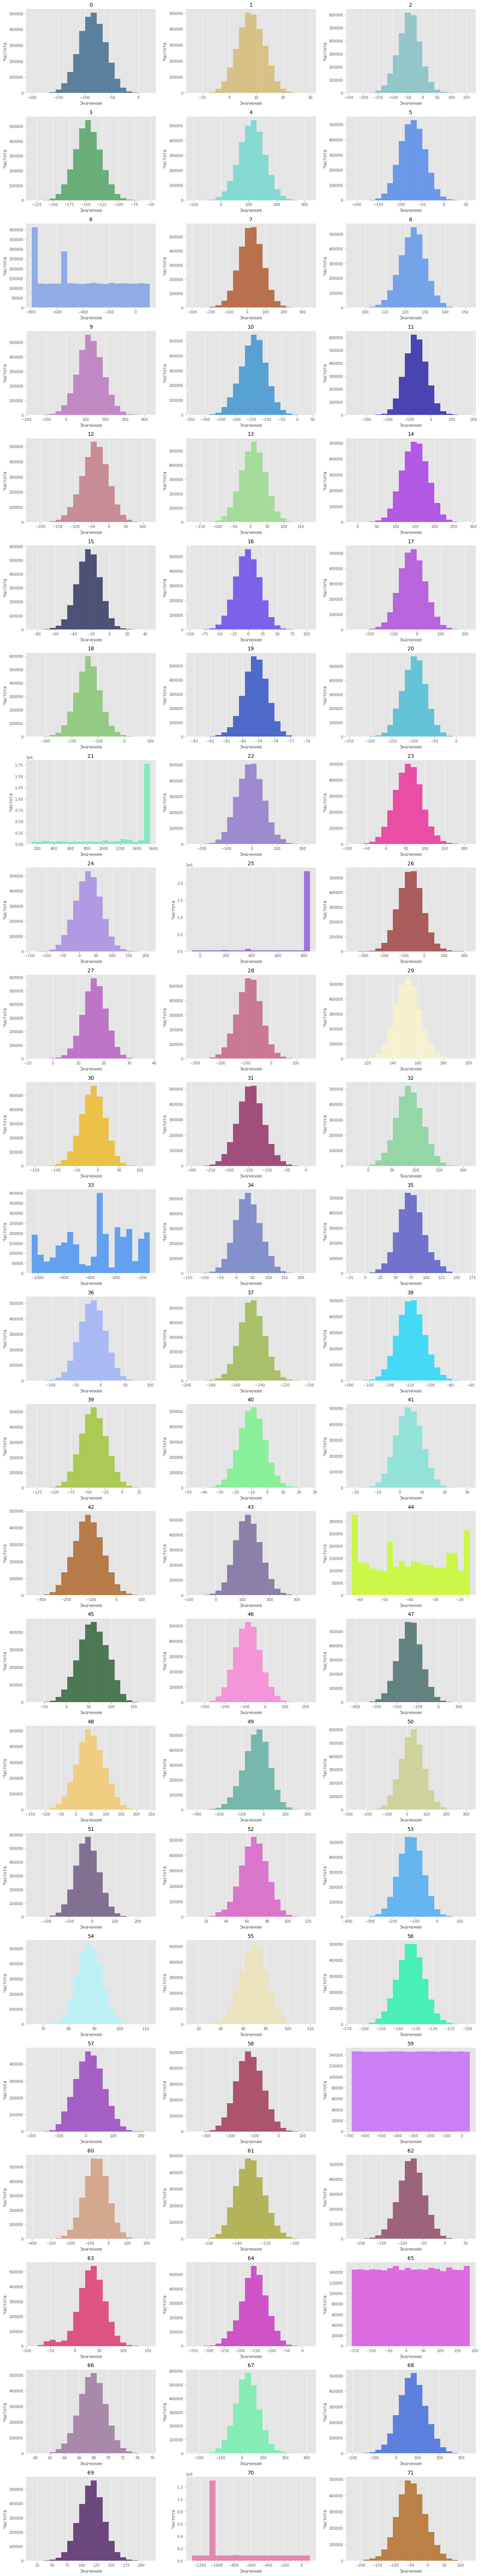

In [7]:
plot_distribution(base_df)

**В все признаки распределены нормально, но стоит отметить такие колонки как: `6`, `21`, `25`, `33`, `44`, `59`, `62`, `65` и `72`. Их стоит рассмотрить более подробно.**

In [8]:
# analyze_column(base_df, '6')

**Благодаря графикам можем заметить, что среди всего распределения выбиваются 2 значения (`-759.626`;`-530.124`) и  имеют частоту `10%` и `6%` соответственно. В осном же все остальные значения распределны равномерно.**

In [9]:
# analyze_column(base_df, '21')

**В 21 признаке самое популярное значение `1507.23`, частота которого `60%`. Остальные значение довольно редкие.**

In [10]:
# analyze_column(base_df, '25')

**Ситуация аналогична, В 25 признаке самое популярное значение `813.77`, частота которого `80%`. Остальные значение довольно редкие.**

In [11]:
# analyze_column(base_df, '33')

**У распределения несколько пиков, которые могут указывать на наличие разных подгрупп в данных. Диапазон значений довольно широк, что может свидетельствовать о большой вариативности измеряемой величины.**

In [12]:
# analyze_column(base_df, '44')

**Наиболее популярные значения колонки № 44 {`-61.44`;`-18.25`}, с частотой 6% и 3% соответсвенно. Также график имеет бимодальное распределение.**

In [13]:
# analyze_column(base_df, '59')

**Исходя из графика, `59` признак имеет равномерное распределение , поэтому каких либо выбивающихся значений из диапазона нет.**

In [14]:
# analyze_column(base_df, '65')

**Ситуация аналогична, В `65` признаке также распределение равномерное, но также изредка есть выбивающиеся значения.**

In [15]:
# analyze_column(base_df, '70')

**Наиболее популярные значения колонки № 70 `-1074`, с частотой `42%`. Другие значения довольно редкие.**

### Вывод ###


- **В целом значения распределены равномерно. Некоторые колонки имеют особенности.**


## Train ##

`Train` *- набор из товаров новых поставок, для которых известны соответствующие товары из "старого" датасета `base`. `ID` этого товара содержится в отдельном датасете `target`.*


In [16]:
# вывод общей информации
display(train_df.head())
train_df.info()
print('Кол-во товаров-дубликатов:', train_df.duplicated().sum())

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,target
id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

**Выделим целевой признак из обучающей выборки**

In [17]:
train_targets = train_df['target']
train_df.drop('target', axis=1, inplace=True)

## Valid ##

`Valid` - набор из товаров новых поставок, для которых НЕ известны соответствующие товары и их необходимо найти.

In [18]:
# вывод общей информации
display(valid_df.head())
valid_df.info()
print('Кол-во товаров-дубликатов:', valid_df.duplicated().sum())

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

`Valid_answer` - верные соответствующие товары для выборки Valid. Необходимо для тестирования обученной модели.

In [19]:
display(valid_targets.head())
valid_targets.info()
print('Кол-во товаров-дубликатов:', valid_targets.duplicated().sum())

,expected
id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
Кол-во товаров-дубликатов: 8498


## Корреляция ##

In [20]:
# f, ax = plt.subplots(figsize=(13, 10))
# phik_matrix = train_df.phik_matrix(interval_cols=train_df.columns)
# sns.heatmap(phik_matrix)
# plt.title('Матрица коэффициентов корреляции Фи (Phi)')
# plt.show()

## Вывод ##

- Пропуски - отсутствуют.

- Выбросы / аномалии - отсутствует. 
- Присутствует "дисбаланс" между значениями. А именно, некоторые значения встречаются особо часто в сравнении со всеми остальными. К примеру: для признака №25 особо популярен значение 813.77. Оно встречается у 80% товаров.

- Дубликаты - отсутствуют, за исключением Valid_answer. Это может говорить, что одному и тому же "старому" товару, может соответствовать несколько "новых".

- Явная зависимость между признаками - отсутствует. Все характеристики уникальны.

- Диапозон широкий значений признаков сильно отличаются друг от друга. Они могут быть как положительными, так и отрицательными. Могут занимать широкий или узкий числовой диапазон. Данные необходимо провести масштабирование.

# Масштабирование #


In [21]:
scaler = StandardScaler()
scaler.fit(base_df)
base_transform  = scaler.transform(base_df)
train_transform = scaler.transform(train_df)
valid_transform = scaler.transform(valid_df)

# пример
print('Пример масштабированного вектора из "base":\n',  base_transform[0],  '\n')
print('Пример масштабированного вектора из "train":\n', train_transform[0], '\n')
print('Пример масштабированного вектора из "valid":\n', valid_transform[0], '\n')

Пример масштабированного вектора из "base":
 [-1.15921621  0.62035039 -0.51372266  1.39855776  2.26904345 -1.16038496
 -0.28288362  0.37366256 -0.43562659  0.88454365  0.4576469   0.73073908
 -0.41463426  0.78201584  1.00285473 -0.37510107 -0.20510187  0.33189056
  0.99042818 -0.36617164 -0.2019014   0.62431793 -0.49577625 -0.1530666
 -2.01843422  0.42159108  0.40135749 -1.69555507 -0.89876331 -0.29430765
  0.05313913  0.03532411 -0.26462494  0.06513401 -0.83885471  1.69344411
  0.80234648 -0.67295311 -0.38906162  0.1131067  -0.40123943 -1.40868981
 -0.70640697 -0.96219636 -1.19775652 -1.29778618 -0.22126234  0.00696112
  0.9529048  -2.37308311 -1.29941832  1.57543507  0.84989106  0.52136797
  0.28986782  0.88773797  0.43402009 -1.13324375  0.70881925  1.52490547
  0.00679186 -0.84751261  1.18904887  0.19052392  0.07358854 -0.89478931
 -2.26249347 -0.51043767  0.29300367 -0.0140507   1.78141979 -0.31232868] 

Пример масштабированного вектора из "train":
 [ 1.29951853  1.99688841  0.063

**Данные готовы для обработки.**

# Faiss #

**На этом этапе данные будут преобразованы из датафрейма в двумерный массив и в результате этого потеряют свои уникальные id. Заблаговременно необходимо создать словарь для сопоставления порядкового номера вектора и id товара**

In [22]:
# словарь id и номеров векторов
base_index = {k: v for k, v in enumerate(base_df.index.to_list())}

print('Пример содержания словаря:\n', list(base_index.items())[0:3])

Пример содержания словаря:
 [(0, '0-base'), (1, '1-base'), (2, '2-base')]


- `FlatL2` - мера близости вектором L2-норма.

- `quantizer` - квантизатор, который получает на вход вектора размерностью `dimensions` и рассчитывает расстояние между ними по евклидовой норме.

- `idx_l2` - пространство векторов размерностью `dimensions`, разделяемое на фиксированное кол-во кластеров из `N_CLUSTERS` с помощью `quantizer`.

In [23]:
dimensions = base_transform.shape[1] 

quantizer = faiss.IndexFlatL2(dimensions)
idx_l2 = faiss.IndexIVFFlat(quantizer, dimensions, N_CLUSTERS)

**Функция `np.ascontiguousarray()` располагает последовательно весь массив данных в оперативной памяти.**

In [24]:
# обучение делителя пространства на первых 50 тысячах объектов из df_base
idx_l2.train(np.ascontiguousarray(base_transform[:50000, :]).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))

**Далее следует процесс поиска соседей. Дословно строчка кода звучит так: для каждого вектора из train_transform найди по N ближайших векторов из df_base (которые уже размечены на отдельные кластеры). Результатом являются:**

- idx - порядковые номера ближайших векторов
- distance - расстояние между векторами.

**Этот процесс может быть долгим. Время вычисления сильно зависит от кол-ва кластеров.**

In [25]:
distance, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), K_NEIGHBORS)

print('Примеры train_idx :\n', train_idx[:3], '\n')
print('Примеры distance :\n', distance[:3])
del distance

Примеры train_idx :
 [[ 598613  755584  336969 1934845   13374 1136231  480296  583287 2360257
   450667  988777 1653095 1818641  503716 1631947   89840  143978  986050
   629775 2346335  223859  352715  455829 1747988 1674977  443428 2295048
   728097 1113711 1746258  751217  854264  792610 1375244  199196 2212973
  2398299 1679537  679629  684958  669932  108138 1285249  725525 1546520
   458465 1299775 1307670 2331892  547719]
 [  15185  902634  223456  464427 2524968  838522  124343 2162616 1325497
   295462 1946148  224544  898791  412497 2469267 2584784    2133 2175159
  1747103 1252594  413070 1445783  838183  690454 1125764  809896 2046499
  2014945   51220 1886873  311357 1405553 1412188  217284 2733705 2876234
  1230304 2151558 1616540 2626152 1036673 1393708  395014  372055 2490004
  2781935 1475385 1369089  110845 2728213]
 [ 173120 1784963 2863071 1143288  955831  137853 1368891 1162532  774247
  1984148 1479188 1238526 2351134  641280 1532675 1774212  948608   12304
  239

In [26]:
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)

In [27]:
print('accuracy@{}: {:.2f}%'.format(K_NEIGHBORS, accuracy_n(train_targets, train_idx)))

accuracy@50: 62.29%


## Ранжирование


**Теперь стоит создать датафрейм, который будт состоять 2 половин:**

- Искомые векторы
- Несколько кандидатов на сопоставление для каждого искомого вектора.


**Последним столбцом для этого вектора станет `matching` содержащий правильный ответ: 1 - вектор подходит, 0 - вектор не подходим.**

In [28]:
# подготовка датафрейма с перечнем ID новых и старых объектов
idx_df = pd.DataFrame(data=train_idx, index=train_df.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

display(idx_df)

,id_query,id_candidate
0,0-query,675816-base
1,0-query,877519-base
2,0-query,361564-base
3,0-query,2725256-base
4,0-query,13406-base
...,...,...
4999995,99999-query,239216-base
4999996,99999-query,1365058-base
4999997,99999-query,4628779-base
4999998,99999-query,569638-base


In [29]:
base_transform_df  = pd.DataFrame(base_transform,  index=base_df.index)
train_transform_df = pd.DataFrame(train_transform, index=train_df.index)
valid_transform_df = pd.DataFrame(valid_transform, index=valid_df.index)

# объединение base и train по заготовленным id
train_base_df = idx_df.merge(train_transform_df, left_on='id_query', right_on='id', how='left')
train_base_df = train_base_df.merge(base_transform_df, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
train_base_df = train_base_df.merge(train_targets, left_on='id_query', right_on='id', how='left')
display(train_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,...,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base,target
0,0-query,675816-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902,675816-base
1,0-query,877519-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560,675816-base
2,0-query,361564-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,1.723392,-0.369458,0.988497,-1.100241,0.280916,-0.492041,0.532096,0.543575,0.090279,675816-base
3,0-query,2725256-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,2.073714,-0.360444,-0.335696,-1.196697,0.156157,-1.269117,0.007341,1.964740,0.834797,675816-base
4,0-query,13406-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,...,1.725501,-0.582972,-0.973235,-0.608757,0.321407,-0.678275,0.164748,2.281264,0.505112,675816-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,99999-query,239216-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,...,-0.556192,0.684536,-1.084027,0.150794,-0.192824,1.158787,1.809290,-0.713847,-0.519473,2769109-base
4999996,99999-query,1365058-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,...,-0.160225,-0.085830,0.219114,-0.344030,0.350846,1.517193,1.509195,-0.257649,-0.930244,2769109-base
4999997,99999-query,4628779-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,...,-1.108153,0.161817,1.325729,0.217945,0.353001,1.909667,0.454184,1.210736,0.426520,2769109-base
4999998,99999-query,569638-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,...,-0.551359,0.061942,0.112904,0.257350,0.056907,0.979424,0.905572,-0.713847,-0.118414,2769109-base


In [30]:
# преобразование целевого признака для бинарной классификации
train_base_df['matching'] = (train_base_df['id_candidate'] == train_base_df['target']).astype('int')
display(train_base_df[['id_query', 'id_candidate', 'target', 'matching']])
train_base_df.drop('target', axis=1, inplace=True)

,id_query,id_candidate,target,matching
0,0-query,675816-base,675816-base,1
1,0-query,877519-base,675816-base,0
2,0-query,361564-base,675816-base,0
3,0-query,2725256-base,675816-base,0
4,0-query,13406-base,675816-base,0
...,...,...,...,...
4999995,99999-query,239216-base,2769109-base,0
4999996,99999-query,1365058-base,2769109-base,0
4999997,99999-query,4628779-base,2769109-base,0
4999998,99999-query,569638-base,2769109-base,0


In [31]:
# выделение признаков и таргета
y_train = train_base_df['matching']
X_train = train_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_train.to_frame())
display(X_train)

,matching
0,1
1,0
2,0
3,0
4,0
...,...
4999995,0
4999996,0
4999997,0
4999998,0


,0,1,2,3,4,5,6,7,8,9,...,62_base,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base
0,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.927103,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902
1,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
2,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.332150,1.723392,-0.369458,0.988497,-1.100241,0.280916,-0.492041,0.532096,0.543575,0.090279
3,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.514269,2.073714,-0.360444,-0.335696,-1.196697,0.156157,-1.269117,0.007341,1.964740,0.834797
4,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.281062,1.725501,-0.582972,-0.973235,-0.608757,0.321407,-0.678275,0.164748,2.281264,0.505112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,-0.794043,...,-0.849041,-0.556192,0.684536,-1.084027,0.150794,-0.192824,1.158787,1.809290,-0.713847,-0.519473
4999996,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,-0.794043,...,-0.824905,-0.160225,-0.085830,0.219114,-0.344030,0.350846,1.517193,1.509195,-0.257649,-0.930244
4999997,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,-0.794043,...,-1.360350,-1.108153,0.161817,1.325729,0.217945,0.353001,1.909667,0.454184,1.210736,0.426520
4999998,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,1.149390,0.885642,-0.902251,-0.794043,...,-1.076139,-0.551359,0.061942,0.112904,0.257350,0.056907,0.979424,0.905572,-0.713847,-0.118414


**В результате получилась выборка для обучения:**

- 5 000 000 записей 
- 144 признака = 72 признака "старых" товаров из base + 72 признака "новых" товаров из train.
- бинарный целевой признак.

## Формирование валидационной выборки


In [32]:
# поиск ближайших соседей для валидационной выборки
vectors, valid_idx = idx_l2.search(np.ascontiguousarray(valid_transform), K_NEIGHBORS)

print('Примеры idx :\n', valid_idx[:3], '\n')
print('accuracy@{}: {:.2f}%'.format(K_NEIGHBORS, accuracy_n(valid_targets['expected'], valid_idx)))
del vectors

Примеры idx :
 [[2192372 2177660  342838  574649 1954150 2363873 1225777 1405698 2910875
  1719453 2512787 2504096 1243148 2571634  536120  995930  462353  814942
  1508869 2536973 2239161  340288  106841  999102  277780 2875559 2886161
  1837653 1952068 1869523 2546410 1037237 2664485 1781035 1660795  270881
  1359889 2508079  925319 1520306 1595615 1944289  369979 1626118  231615
  2560782 1043785 1833780 1566084 2798620]
 [2580959 2561209 2242396 1181240 1902639 1274898 2569205 2409971  804468
  2823570 2402606  997709 1310649 1501018 1000466  296658   63166 1134043
  2445188 2051707 2592310  367614 1972162 1236324 2800021 2172750 1350091
  1989911  119053  785717 1722415   62010  522842  605593 2745757 2040410
   676553 1955017  822207 2614418  603169 1172242  685592 2231420 1601172
   277068  290024  116339 2755206  236990]
 [ 431806  148400  451870  281105   24989  685598  365989  279417  674511
   318265  832464  195078  389136  359945  208180  586213 2154246  119568
   171490  

In [33]:
# подготовка датафрейма с перечнем ID новых и старых объектов
idx_df = pd.DataFrame(data=valid_idx, index=valid_df.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

display(idx_df)

,id_query,id_candidate
0,100000-query,3209652-base
1,100000-query,3181043-base
2,100000-query,368296-base
3,100000-query,645855-base
4,100000-query,2760762-base
...,...,...
4999995,199999-query,921521-base
4999996,199999-query,712634-base
4999997,199999-query,2201401-base
4999998,199999-query,2164289-base


In [34]:
# объединение base и valid по списку ближайших соседей
valid_base_df = idx_df.merge(valid_transform_df, left_on='id_query', right_on='id', how='left')
valid_base_df = valid_base_df.merge(base_transform_df, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
valid_base_df = valid_base_df.merge(valid_targets, left_on='id_query', right_on='id', how='left')
display(valid_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,...,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base,expected
0,100000-query,3209652-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590,2676668-base
1,100000-query,3181043-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064,2676668-base
2,100000-query,368296-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.011799,0.883902,1.235784,0.495694,0.563696,0.170485,-0.324675,-1.051440,-1.097352,2676668-base
3,100000-query,645855-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.174387,0.044383,0.015341,-0.042959,0.317641,0.067884,0.540182,-0.713847,-1.343913,2676668-base
4,100000-query,2760762-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,...,0.089266,0.047589,0.222569,0.533942,1.168393,-0.104937,0.162421,-0.005964,-1.245106,2676668-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,199999-query,921521-base,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,...,-0.306112,-0.283584,0.651956,-0.642085,-1.405351,-0.000845,0.208061,1.277010,-0.476434,336472-base
4999996,199999-query,712634-base,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,...,-0.782172,-0.007897,1.320489,-0.945285,-0.683240,0.655517,0.893011,0.331360,-0.491120,336472-base
4999997,199999-query,2201401-base,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,...,-0.196261,-0.069830,-0.402850,-1.942298,-0.466847,0.215891,0.948008,-0.713847,-0.608511,336472-base
4999998,199999-query,2164289-base,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,...,-0.449165,-0.615107,0.815837,-0.282646,-0.236910,1.403467,1.050669,1.209107,-0.647278,336472-base


In [35]:
# преобразование целевого признака для бинарной классификации
valid_base_df['matching'] = (valid_base_df['id_candidate'] == valid_base_df['expected']).astype('int')
display(valid_base_df[['id_query', 'id_candidate', 'expected', 'matching']])
valid_base_df.drop('expected', axis=1, inplace=True)

,id_query,id_candidate,expected,matching
0,100000-query,3209652-base,2676668-base,0
1,100000-query,3181043-base,2676668-base,0
2,100000-query,368296-base,2676668-base,0
3,100000-query,645855-base,2676668-base,0
4,100000-query,2760762-base,2676668-base,0
...,...,...,...,...
4999995,199999-query,921521-base,336472-base,0
4999996,199999-query,712634-base,336472-base,0
4999997,199999-query,2201401-base,336472-base,0
4999998,199999-query,2164289-base,336472-base,0


In [36]:
# выделение признаков и таргета
y_valid = valid_base_df['matching']
X_valid = valid_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_valid.to_frame())
display(X_valid)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
4999995,0
4999996,0
4999997,0
4999998,0


,0,1,2,3,4,5,6,7,8,9,...,62_base,63_base,64_base,65_base,66_base,67_base,68_base,69_base,70_base,71_base
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.457506,0.948873,0.570802,1.213205,0.909867,0.897679,0.018913,0.430446,-0.713847,-1.182590
1,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.190811,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406469,-0.713847,-1.284064
2,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,-0.228085,0.011799,0.883902,1.235784,0.495694,0.563696,0.170485,-0.324675,-1.051440,-1.097352
3,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.062169,0.174387,0.044383,0.015341,-0.042959,0.317641,0.067884,0.540182,-0.713847,-1.343913
4,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,-0.061286,0.089266,0.047589,0.222569,0.533942,1.168393,-0.104937,0.162421,-0.005964,-1.245106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,-0.659733,-1.092404,...,-1.575133,-0.306112,-0.283584,0.651956,-0.642085,-1.405351,-0.000845,0.208061,1.277010,-0.476434
4999996,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,-0.659733,-1.092404,...,-0.805839,-0.782172,-0.007897,1.320489,-0.945285,-0.683240,0.655517,0.893011,0.331360,-0.491120
4999997,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,-0.659733,-1.092404,...,-0.643643,-0.196261,-0.069830,-0.402850,-1.942298,-0.466847,0.215891,0.948008,-0.713847,-0.608511
4999998,1.826818,-0.251821,0.377601,-0.487493,-0.053289,0.448831,-0.776387,-0.978521,-0.659733,-1.092404,...,-0.946138,-0.449165,-0.615107,0.815837,-0.282646,-0.236910,1.403467,1.050669,1.209107,-0.647278


**Данные подготовлены для обучения и теста модели. Теперь можно почистить неиспользуемые данные.**

In [37]:
# освобождение памяти
del base_transform
del train_transform
del valid_transform

del base_transform_df
del train_transform_df
del valid_transform_df

del train_idx
del valid_idx
del idx_df

# Модели

## Логистическая регрессия


In [38]:
model = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train, y_train)

valid_predictions = model.predict(X_valid)
valid_probabilities = model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, valid_predictions)

print('valid_accuracy: {:.2%}'.format(valid_accuracy))

valid_accuracy: 60.56%


In [39]:
valid_proba_series = pd.Series(valid_probabilities)

valid_candidates = []
for i in range(0, len(valid_proba_series), K_NEIGHBORS):
    query = valid_proba_series[i : i+K_NEIGHBORS]
    index = query.sort_values(ascending=False)[0:N_CELLS].index
    valid_candidates.append(index)

# контроль
print('Кол-во предсказаний:', len(valid_candidates))
print('Кол-во кандидатов:', len(valid_candidates[0]))

Кол-во предсказаний: 100000
Кол-во кандидатов: 5


In [40]:
# оценка качества
acc = 0
for target, candidates in zip(valid_targets.values.tolist(), valid_candidates):
    acc += int(target in valid_base_df.loc[candidates, 'id_candidate'].values)

print('valid_accuracy@{}: {:.2f}%'.format(N_CELLS, acc / len(valid_candidates) * 100))

valid_accuracy@5: 11.51%


# Вывод

- Исходные данные имеют хорошее качество. Тип данных - соответствует. Пропуски, дубликаты, выбросы / аномалии - отсутствуют. Тем не менее, существует "дисбаланс" между значениями. 

- Поскольку значения признаков сильно отличаются друг от друга все признаки были масштабированы.

- Было создано и наполнено векторное пространство из объектов датасета base. .

- По результату поиска ближайших соседей для 62.29% новых товара из train найдено 20 кандидатов, среди которах есть целевой (т.е. верно подобранный экспертом).

- Далее, среди найденных кандидатов были выделены пятерки самых подходящий. Для этого их применялась Логистическая регрессия. Присутствующий негативный эффект дисбаланса классов был уменьшен с помощью штатного гиперпараметра модели class_weight, тем самым назначив разные веса для классов.

- Итоговое значение целевой метрики 11.51%.


***P.S Честно говоря не хватило времени на полную реализацию проекта (т.к. он требует много ресурсов) и поэтому  не было сделано ряд дейтсвий таких как:***
- Подобрать другое кол-во ближайших соседей на этапе поиска. Но в обязательном порядке решить проблему дисбаланса классов.
- Установить большее кол-во кластеров для деления векторного пространства.
- Попробовать другие ML-модели,

***К сожалению, мне не хватило времени реализовать это к сроку сдачи проекта и полностью разобраться в теме, хотелось бы услышать ряд полезных рекомендаций и ссылок, что будет качественно закончить проект.***